# Taxi tip prediction
*June 2021*

This notebook aims to predict two target variables using the New York taxi trip dataset, namely `fare_amount` and `tip_amount`.

Data cleaning and feature engineering will first be performed. Following that, three ensemble methods - Random Forest, Adaboost, Gradient Boosting - will be used. 

### Introduction

We first import the relevant libraries and read in the data from the csv files.

In [50]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn import ensemble, metrics, model_selection, preprocessing
from matplotlib import pyplot as plt

In [51]:
taxi_train = pd.read_csv("taxi-train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
taxi_test = pd.read_csv("taxi-test.csv")

In [52]:
taxi_train.head()

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tip_paid
0,CMT,2013-11-03 18:11:18+00:00,2013-11-03 18:18:43+00:00,-73.971879,40.756228,-73.971428,40.764175,1.0,1,0.80,CSH,6.5,0.00,0
1,CMT,2010-06-30 17:30:34+00:00,2010-06-30 17:40:44+00:00,-73.977850,40.738361,-73.977073,40.754229,1.0,1,1.50,Cre,6.9,1.88,1
2,CMT,2010-03-03 10:10:25+00:00,2010-03-03 10:19:38+00:00,-73.974089,40.762479,-73.990669,40.745668,1.0,1,1.60,Cre,6.9,1.00,1
3,VTS,2012-04-17 11:51:00+00:00,2012-04-17 12:07:00+00:00,-73.979920,40.781045,-73.970415,40.765608,1.0,1,1.70,CRD,9.7,1.94,1
4,VTS,2012-03-30 14:26:00+00:00,2012-03-30 14:36:00+00:00,-73.972975,40.761610,-73.955615,40.764290,1.0,2,1.36,CSH,6.9,0.00,0


### Data cleaning

We first perform some basic data cleaning on the training dataset, before it is split into train, test and validation datasets.

#### Missing values

All columns except `rate_code` do not have any missing values. Since a substantial proportion of values (more than 100,000) in the `rate_code` column are missing, the column will be dropped and not included in the analysis.

In [54]:
taxi_train.isna().sum()

vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
rate_code            173216
passenger_count           0
trip_distance             0
payment_type              0
fare_amount               0
tip_amount                0
tip_paid                  0
dtype: int64

#### Outliers

A brief look at the variables seems to indicate that there are no significant outliers in the data that need to be cleaned - both minimum and maximum values in the `passenger_count` and `trip_distance` columns appear to be reasonable.

In [53]:
taxi_train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,rate_code,passenger_count,trip_distance,fare_amount,tip_amount,tip_paid
count,1.071910e+06,1.071910e+06,1.071910e+06,1.071910e+06,898694.000000,1.071910e+06,1.071910e+06,1.071910e+06,1.071910e+06,1.071910e+06
mean,-7.397707e+01,4.075684e+01,-7.397554e+01,4.075727e+01,1.004778,1.691701e+00,1.812045e+00,8.456763e+00,7.843356e-01,4.227939e-01
std,1.437120e-02,1.819315e-02,1.573655e-02,1.885316e-02,0.157091,1.312070e+00,1.221569e+00,4.017411e+00,1.190242e+00,4.940035e-01
min,-7.400000e+01,4.070000e+01,-7.400000e+01,4.070000e+01,0.000000,1.000000e+00,1.000000e-02,2.500000e+00,0.000000e+00,0.000000e+00
25%,-7.398816e+01,4.074478e+01,-7.398730e+01,4.074532e+01,1.000000,1.000000e+00,9.500000e-01,5.700000e+00,0.000000e+00,0.000000e+00
50%,-7.397982e+01,4.075782e+01,-7.397857e+01,4.075826e+01,1.000000,1.000000e+00,1.500000e+00,7.500000e+00,0.000000e+00,0.000000e+00
75%,-7.396813e+01,4.076944e+01,-7.396649e+01,4.077046e+01,1.000000,2.000000e+00,2.300000e+00,1.010000e+01,1.500000e+00,1.000000e+00
max,-7.390001e+01,4.080000e+01,-7.390001e+01,4.080000e+01,99.000000,6.000000e+00,1.680000e+01,2.000000e+02,1.444000e+02,1.000000e+00


#### Standardisation and one-hot encoding

The `payment_type` column appears to have duplicate values. A quick check on the data source at [TLC](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) indicates that there are 6 payment types, namely:

- Credit card
- Cash
- No charge
- Dispute
- Unknown
- Voided trip

No charge, dispute, unknown and voided trip are group together to form an 'Other' group, since each category has few data points. The values in the column are standardised to reflect only these 3 categories. Since the column contains a few number of categories, one-hot encoding will be suitable.

In [55]:
taxi_train['payment_type'].value_counts()

CSH    545180
CRD    434636
CAS     33097
Cas     27046
Cre     26436
CRE      2856
NOC      1142
UNK      1035
DIS       300
No        131
Dis        28
NA         23
Name: payment_type, dtype: int64

In [56]:
corrections = {"CSH": "cash", "CAS": "cash", "Cas": "cash", 
               "CRD": "credit", "Cre": "credit", "CRE": "credit",
               "NOC": "other", "No ": "other",
               "UNK": "other",
               "DIS": "other",               
               "NA ": "other"
              }

taxi_train['payment_type'] = taxi_train['payment_type'].map(corrections)

In [57]:
taxi_train['payment_type'].value_counts()

cash      605323
credit    463928
other       2631
Name: payment_type, dtype: int64

One-hot encoding also appears to be suitable for the `vendor_id` column.

In [58]:
taxi_train['vendor_id'].value_counts()

VTS    539286
CMT    520331
DDS     12293
Name: vendor_id, dtype: int64

### Data splitting

Since we have decided which columns to drop and which columns are suitable for one-hot encoding, we proceed to split the training data into `trainval` (80%) and `test` (20%) datasets.

The `trainval` data will be further split into train and validation datasets after EDA and feature engineering are performed.

In [59]:
x = taxi_train.iloc[:,:-3]
y = taxi_train.loc[:,['fare_amount', 'tip_amount']]

In [60]:
x_trainval, x_test, y_trainval, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=42)

### Exploratory data analysis and feature engineering

We'll focus on the `x_trainval` dataset for EDA and feature engineering.

#### Drop columns with missing values

We drop the earlier identified `rate_code` column which had many missing values.

In [61]:
del x_trainval['rate_code']

####  One-hot encoding

We earlier identified two columns containing categorical data suitable for one-hot encoding, namely `payment_type` and `vendor_id`.

In [62]:
x_trainval = pd.get_dummies(x_trainval, columns = ["payment_type"])
x_trainval = pd.get_dummies(x_trainval, columns = ["vendor_id"])

#### Parsing date and time data

Next, the following columns are added to parse the datetime columns. Pick up and drop off times are first converted to Eastern Time, which is 4 hours ahead of UTC.

- Trip duration in minutes
- Pick up hour
- Year
- Month
- Day of week

Year, Month and Day of week are based on the pick up date column.

In [63]:
x_trainval['pickup_datetime'] = x_trainval['pickup_datetime'] + dt.timedelta(hours = 4)
x_trainval['dropoff_datetime'] = x_trainval['dropoff_datetime'] + dt.timedelta(hours = 4)

x_trainval['trip_duration'] = (x_trainval['dropoff_datetime'] - x_trainval['pickup_datetime']).dt.total_seconds() / 60
x_trainval['start_hour'] = x_trainval['pickup_datetime'].dt.hour
x_trainval['year'] = x_trainval['pickup_datetime'].dt.year
x_trainval['month'] = x_trainval['pickup_datetime'].dt.month
x_trainval['day_of_week'] = x_trainval['pickup_datetime'].dt.dayofweek

Since we've extracted the relevant features from the datetime columns, we'll proceed to remove these columns

In [73]:
del x_trainval['pickup_datetime']
del x_trainval['dropoff_datetime']

In [74]:
x_trainval.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,payment_type_cash,payment_type_credit,payment_type_other,vendor_id_CMT,vendor_id_DDS,vendor_id_VTS,trip_duration,start_hour,year,month,day_of_week
890912,-73.957390,40.782142,-73.953657,40.778632,6,0.40,1,0,0,0,0,1,3.000000,21,2014,5,0
67095,-73.977510,40.753517,-73.968020,40.759915,6,0.93,1,0,0,0,0,1,8.000000,22,2013,3,2
341589,-73.997130,40.744120,-73.986122,40.728143,1,1.70,1,0,0,1,0,0,7.950000,5,2013,7,6
139057,-73.981953,40.778552,-73.981857,40.755243,1,1.90,1,0,0,1,0,0,8.900000,11,2009,4,3
762690,-73.957855,40.769614,-73.967636,40.763782,1,0.80,1,0,0,1,0,0,3.433333,1,2009,3,4


#### Data visualisation

Next, we take a look at the correlation of each variable to both the fare amount and tip amount.

Text(0.5, 1.0, 'Correlation with Fare Amount')

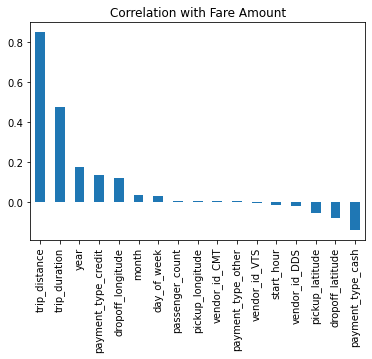

In [75]:
x_trainval.corrwith(y_trainval["fare_amount"]).sort_values(ascending = False).plot.bar()
plt.title('Correlation with Fare Amount')

The variables with the highest correlation with fare amount are not particularly surprising - as expected, trip distance and trip duration are the most positively correlated with the fare amount. 

The year variable is positively correlated with fare amount, possibly due to inflationary effects through the years. Interestingly, credit card payments are also positively correlated with the fare amount, while the inverse is true for cash payments. One hypothesis may be that individuals paying via credit card may be more affluent, and hence are able and willing to take taxi trips for greater distances.

Lastly, both pick up and drop off latitude are negatively correlated with fare amount - this could be due to the locations of various neighbourhoods and the differences in demographics (e.g., the Financial District is located downtown, where business trips may take place).

We'll take a look at correlations with tip amounts next.

Text(0.5, 1.0, 'Correlation with Tip Amount')

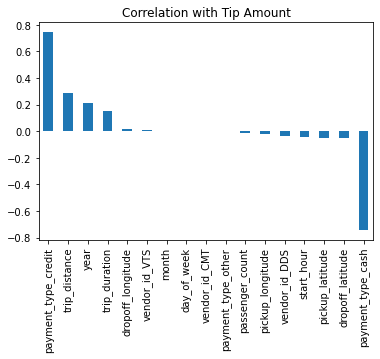

In [76]:
x_trainval.corrwith(y_trainval["tip_amount"]).sort_values(ascending = False).plot.bar()
plt.title('Correlation with Tip Amount')

Perhaps unsurprisingly, the variables with the highest correlation with tip amount are credit card and cash payments. This intuitively makes sense as the process of tipping is much easier when card payments are performed, as the tip percentages can be automatically calculated and added to the total fare as the card payment is made.

Other key factors include trip distance - tips are likely to be proportional to the fare amount, which is highly correlated to the distance of the trip. Due to inflationary effects, year is also positively correlated with tip amounts. 

#### Data splitting

Since we have completed EDA and feature engineering, we'll proceed to further split the `trainval` dataset into training and validation datasets. 

The data has been split into 85% training, 25% validation, such that the final split between training, test and validation is 60%, 20% and 20%.

In [78]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_trainval, y_trainval, test_size=0.25, random_state=42)

#### Performing feature engineering on test data

Lastly, before the modelling step, we perform the same feature engineering steps on the test data.

In [91]:
del x_test['rate_code']

x_test = pd.get_dummies(x_test, columns = ["payment_type"])
x_test = pd.get_dummies(x_test, columns = ["vendor_id"])

x_test['pickup_datetime'] = x_test['pickup_datetime'] + dt.timedelta(hours = 4)
x_test['dropoff_datetime'] = x_test['dropoff_datetime'] + dt.timedelta(hours = 4)
x_test['trip_duration'] = (x_test['dropoff_datetime'] - x_test['pickup_datetime']).dt.total_seconds() / 60
x_test['start_hour'] = x_test['pickup_datetime'].dt.hour
x_test['year'] = x_test['pickup_datetime'].dt.year
x_test['month'] = x_test['pickup_datetime'].dt.month
x_test['day_of_week'] = x_test['pickup_datetime'].dt.dayofweek

del x_test['pickup_datetime']
del x_test['dropoff_datetime']

### Modelling

We next move on to modelling. Three ensemble models will be used, namely:

- Random Forest Regressor
- AdaBoost Regressor
- Gradient Boosting Regressor

#### Random Forest Regressor

We first run a baseline random forest model with `n_estimators` = 10, with RMSE being the objective metric.

In [80]:
# Fare prediction - baseline model

rforest_f = ensemble.RandomForestRegressor(n_estimators = 10, random_state = 42)
rforest_f.fit(x_train, y_train["fare_amount"])

y_pred_f = rforest_f.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_f, y_val["fare_amount"], squared = False)
print("RMSE: ", rmse)

RMSE:  1.2609065480754478


In [81]:
# Tip prediction - baseline model

rforest_t = ensemble.RandomForestRegressor(n_estimators = 10, random_state = 42)
rforest_t.fit(x_train, y_train["tip_amount"])

y_pred_t = rforest_t.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_t, y_val["tip_amount"], squared = False)
print("RMSE: ", rmse)

RMSE:  0.7585557387895477


Since the parameter space is large, we use `RandomizedSearchCV` to determine the optimal hyperparameters for the random forest. While Grid Search performs an exhaustive search, it can be inefficient. In contrast, Random Search selects random combinations of hyperparameter values, and has been shown to be able to pick the best results at a fraction of the time taken by Grid Search.

In addition, since performing Random Search is extremely computationally expensive, we'll use a subset of the training data in order to speed up the process. Once the best hyperparameter option is found, we will retrain the model with the full training data.

In [82]:
param_grid = {
    # Number of trees in random forest
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)],
    # Maximum number of levels in tree
    'max_depth': [None] + list(np.linspace(10, 100, num = 10).astype(int)),
    # Number of features to consider at each split
    'max_features': ['auto', 'sqrt'],
    # Minimum number of samples to split a node
    'min_samples_split': [2, 5, 10],
    # Whether bootstrap samples are used
    'bootstrap': [True, False]
}

print(param_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]}


In [83]:
# Fare prediction - random search

rs_x_data = x_trainval.sample(100_000, random_state = 42)
rs_y_data = y_trainval["fare_amount"].sample(100_000, random_state = 42)

rforest_f_rs = model_selection.RandomizedSearchCV(ensemble.RandomForestRegressor(), param_grid, n_jobs = -1, 
                                                  scoring = 'neg_root_mean_squared_error', cv = 3, 
                                                  n_iter = 50, verbose = 2, random_state=42)

rforest_f_rs.fit(rs_x_data, rs_y_data)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 32.1min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [84]:
print("Best score: ", rforest_f_rs.best_score_)
print("Best parameters: ", rforest_f_rs.best_params_)

Best score:  -1.1686708911427168
Best parameters:  {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}


In [86]:
# Tip prediction - random search

rs_x_data = x_trainval.sample(100_000, random_state = 42)
rs_y_data = y_trainval["tip_amount"].sample(100_000, random_state = 42)

rforest_t_rs = model_selection.RandomizedSearchCV(ensemble.RandomForestRegressor(), param_grid, n_jobs = -1, 
                                                  scoring = 'neg_root_mean_squared_error', cv = 3, 
                                                  n_iter = 30, verbose = 2, random_state=42)

rforest_t_rs.fit(rs_x_data, rs_y_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 14.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [87]:
print("Best score: ", rforest_t_rs.best_score_)
print("Best parameters: ", rforest_t_rs.best_params_)

Best score:  -0.6690128573483931
Best parameters:  {'n_estimators': 190, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


Once we have obtained the optimal hyperparameters, we train the random forest model on the full dataset to predict both fare and tip amounts.

In [92]:
# Fare prediction - final model

rforest_f_final = ensemble.RandomForestRegressor(n_estimators = 200, min_samples_split = 5, max_features = 'sqrt',
                                                 max_depth = 50, bootstrap = False, random_state = 42)

rforest_f_final.fit(x_train, y_train["fare_amount"])

y_pred_f_val = rforest_f_final.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_f_val, y_val["fare_amount"], squared = False)
print("RMSE (validation data): ", rmse)

y_pred_f_test = rforest_f_final.predict(x_test)
rmse = metrics.mean_squared_error(y_pred_f_test, y_test["fare_amount"], squared = False)
print("RMSE (test data): ", rmse)

RMSE (validation data):  1.1382573212283775
RMSE (test data):  1.05972179097739


In [93]:
# Tip prediction - final model

rforest_t_final = ensemble.RandomForestRegressor(n_estimators = 190, min_samples_split = 10, max_features = 'sqrt',
                                                 max_depth = 30, bootstrap = True, random_state = 42)

rforest_t_final.fit(x_train, y_train["tip_amount"])

y_pred_t_val = rforest_t_final.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_t_val, y_val["tip_amount"], squared = False)
print("RMSE (validation data): ", rmse)

y_pred_t_test = rforest_t_final.predict(x_test)
rmse = metrics.mean_squared_error(y_pred_t_test, y_test["tip_amount"], squared = False)
print("RMSE (test data): ", rmse)

RMSE (validation data):  0.7098668984904992
RMSE (test data):  0.5723543949540788


We can extract the importance of each feature of the final model.

Text(0.5, 0, 'Random Forest Feature Importance (Fare Prediction)')

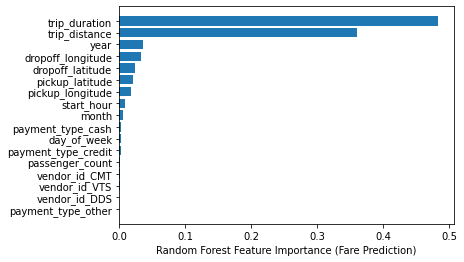

In [95]:
# Fare prediction - feature importance

sorted_idx = rforest_f_final.feature_importances_.argsort()
plt.barh(x_val.columns[sorted_idx], rforest_f_final.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance (Fare Prediction)")

Text(0.5, 0, 'Random Forest Feature Importance (Tip Prediction)')

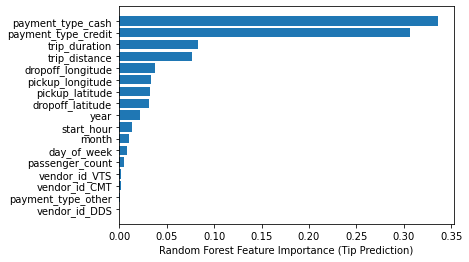

In [97]:
# Tip prediction - feature importance

sorted_idx = rforest_t_final.feature_importances_.argsort()
plt.barh(x_val.columns[sorted_idx], rforest_t_final.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance (Tip Prediction)")

##### Summary

**Random Forest**

Objective metric on test:

- Fare prediction: RMSE = 1.0597
- Tip prediction: RMSE = 0.5724

Parameters: 

- Fare prediction: n_estimators = 200, min_samples_split = 5, max_features = 'sqrt', max_depth = 50, bootstrap = False
- Tip prediction: n_estimators = 190, min_samples_split = 10, max_features = 'sqrt', max_depth = 30, bootstrap = True

Top 5 features:

- Fare prediction: trip duration, trip distance, year, drop-off longitude, drop-off latitude
- Tip prediction: payment type (cash), payment type (credit), trip duration, trip distance, drop-off longitude

#### AdaBoost Regressor

We perform the same steps for the AdaBoost Regressor.

In [98]:
# Fare prediction - baseline model

adaboost_f = ensemble.AdaBoostRegressor(random_state = 42)
adaboost_f.fit(x_train, y_train["fare_amount"])

y_pred_f = adaboost_f.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_f, y_val["fare_amount"], squared = False)
print("RMSE: ", rmse)

RMSE:  9.118481664280985


In [99]:
# Tip prediction - baseline model

adaboost_t = ensemble.AdaBoostRegressor(random_state = 42)
adaboost_t.fit(x_train, y_train["tip_amount"])

y_pred_t = adaboost_t.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_t, y_val["tip_amount"], squared = False)
print("RMSE: ", rmse)

RMSE:  6.7700682554835865


In [100]:
param_grid = {
    # Maximum number of estimators at which boosting is terminated
    'n_estimators': [10, 20, 50, 100, 150, 200, 250, 300],
    # Learning rate
    'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1],
    # Loss function
    'loss' : ['linear', 'square', 'exponential'],
}

print(param_grid)

{'n_estimators': [10, 20, 50, 100, 150, 200, 250, 300], 'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1], 'loss': ['linear', 'square', 'exponential']}


In [101]:
# Fare prediction - random search

ada_x_data = x_trainval.sample(100_000, random_state = 42)
ada_y_data = y_trainval["fare_amount"].sample(100_000, random_state = 42)

adaboost_f_rs = model_selection.RandomizedSearchCV(ensemble.AdaBoostRegressor(), param_grid, n_jobs = -1, 
                                                  scoring = 'neg_root_mean_squared_error', cv = 3, 
                                                  n_iter = 30, verbose = 2, random_state=42)

adaboost_f_rs.fit(ada_x_data, ada_y_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.4min finished


RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.5, 1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [10, 20, 50, 100, 150,
                                                         200, 250, 300]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [102]:
print("Best score: ", adaboost_f_rs.best_score_)
print("Best parameters: ", adaboost_f_rs.best_params_)

Best score:  -1.6972859257180917
Best parameters:  {'n_estimators': 150, 'loss': 'exponential', 'learning_rate': 0.01}


In [103]:
# Tip prediction - random search

ada_x_data = x_trainval.sample(100_000, random_state = 42)
ada_y_data = y_trainval["tip_amount"].sample(100_000, random_state = 42)

adaboost_t_rs = model_selection.RandomizedSearchCV(ensemble.AdaBoostRegressor(), param_grid, n_jobs = -1, 
                                                  scoring = 'neg_root_mean_squared_error', cv = 3, 
                                                  n_iter = 30, verbose = 2, random_state=42)

adaboost_t_rs.fit(ada_x_data, ada_y_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.5min finished


RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.5, 1],
                                        'loss': ['linear', 'square',
                                                 'exponential'],
                                        'n_estimators': [10, 20, 50, 100, 150,
                                                         200, 250, 300]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [104]:
print("Best score: ", adaboost_t_rs.best_score_)
print("Best parameters: ", adaboost_t_rs.best_params_)

Best score:  -0.6988213045301063
Best parameters:  {'n_estimators': 250, 'loss': 'linear', 'learning_rate': 0.001}


In [107]:
# Fare prediction - final model

adaboost_f_final = ensemble.AdaBoostRegressor(n_estimators = 150, loss = 'exponential', 
                                              learning_rate = 0.01, random_state = 42)

adaboost_f_final.fit(x_train, y_train["fare_amount"])

y_pred_f_val = adaboost_f_final.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_f_val, y_val["fare_amount"], squared = False)
print("RMSE (validation data): ", rmse)

y_pred_f_test = adaboost_f_final.predict(x_test)
rmse = metrics.mean_squared_error(y_pred_f_test, y_test["fare_amount"], squared = False)
print("RMSE (test data): ", rmse)

RMSE (validation data):  1.8347632129691915
RMSE (test data):  1.7773191039327447


In [108]:
# Tip prediction - final model

adaboost_t_final = ensemble.AdaBoostRegressor(n_estimators = 250, loss = 'linear', 
                                              learning_rate = 0.001, random_state = 42)

adaboost_t_final.fit(x_train, y_train["tip_amount"])

y_pred_t_val = adaboost_t_final.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_t_val, y_val["tip_amount"], squared = False)
print("RMSE (validation data): ", rmse)

y_pred_t_test = adaboost_t_final.predict(x_test)
rmse = metrics.mean_squared_error(y_pred_t_test, y_test["tip_amount"], squared = False)
print("RMSE (test data): ", rmse)

RMSE (validation data):  0.7420342382222995
RMSE (test data):  0.608906761326686


Text(0.5, 0, 'AdaBoost Feature Importance (Fare Prediction)')

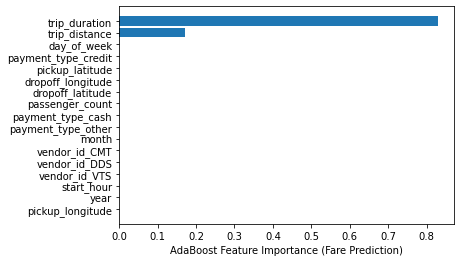

In [109]:
# Fare prediction - feature importance

sorted_idx = adaboost_f_final.feature_importances_.argsort()
plt.barh(x_val.columns[sorted_idx], adaboost_f_final.feature_importances_[sorted_idx])
plt.xlabel("AdaBoost Feature Importance (Fare Prediction)")

Text(0.5, 0, 'AdaBoost Feature Importance (Tip Prediction)')

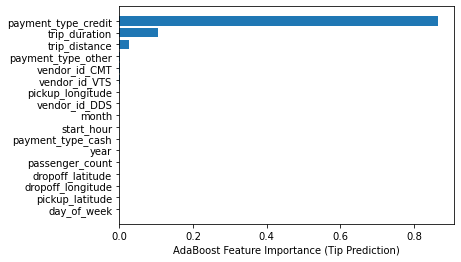

In [110]:
# Tip prediction - feature importance

sorted_idx = adaboost_t_final.feature_importances_.argsort()
plt.barh(x_val.columns[sorted_idx], adaboost_t_final.feature_importances_[sorted_idx])
plt.xlabel("AdaBoost Feature Importance (Tip Prediction)")

##### Summary

**AdaBoost**

Objective metric on test:

- Fare prediction: RMSE = 1.7773
- Tip prediction: RMSE = 0.6089

Parameters: 

- Fare prediction: n_estimators = 150, loss = 'exponential', learning_rate = 0.01
- Tip prediction: n_estimators = 250, loss = 'linear', learning_rate = 0.001

Top 5 features:

- Fare prediction: trip duration, trip distance
- Tip prediction: payment type (credit), trip duration

#### Gradient Boosting Regressor

Lastly, we repeat the same steps for Gradient Boosting Regressor.

In [111]:
# Fare prediction - baseline model

gboost_f = ensemble.GradientBoostingRegressor(random_state = 42)
gboost_f.fit(x_train, y_train["fare_amount"])

y_pred_f = gboost_f.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_f, y_val["fare_amount"], squared = False)
print("RMSE: ", rmse)

RMSE:  1.1749625963958612


In [112]:
# Tip prediction - baseline model

gboost_t = ensemble.GradientBoostingRegressor(random_state = 42)
gboost_t.fit(x_train, y_train["tip_amount"])

y_pred_t = gboost_t.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_t, y_val["tip_amount"], squared = False)
print("RMSE: ", rmse)

RMSE:  0.7124399710346739


In [113]:
param_grid = {
    # Learning rate
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1],
    # Number of boosting estimators
    'n_estimators': [10, 50, 100, 150, 200, 250, 300],  
    # Maximum depth of individual regression estimators
    'max_depth': [1, 2, 5, 8]
}

print(param_grid)

{'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1], 'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_depth': [1, 2, 5, 8]}


In [114]:
# Fare prediction - random search

gb_x_data = x_trainval.sample(100_000, random_state = 42)
gb_y_data = y_trainval["fare_amount"].sample(100_000, random_state = 42)

gboost_f_rs = model_selection.RandomizedSearchCV(ensemble.GradientBoostingRegressor(), param_grid, n_jobs = -1, 
                                                 scoring = 'neg_root_mean_squared_error', cv = 3, 
                                                 n_iter = 30, verbose = 2, random_state=42)

gboost_f_rs.fit(gb_x_data, gb_y_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 14.4min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': [1, 2, 5, 8],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [115]:
print("Best score: ", gboost_f_rs.best_score_)
print("Best parameters: ", gboost_f_rs.best_params_)

Best score:  -1.1352278734378558
Best parameters:  {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}


In [116]:
# Tip prediction - random search

gb_x_data = x_trainval.sample(100_000, random_state = 42)
gb_y_data = y_trainval["tip_amount"].sample(100_000, random_state = 42)

gboost_t_rs = model_selection.RandomizedSearchCV(ensemble.GradientBoostingRegressor(), param_grid, n_jobs = -1, 
                                                 scoring = 'neg_root_mean_squared_error', cv = 3, 
                                                 n_iter = 30, verbose = 2, random_state=42)

gboost_t_rs.fit(gb_x_data, gb_y_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 35.0min finished


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': [1, 2, 5, 8],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         250, 300]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [117]:
print("Best score: ", gboost_t_rs.best_score_)
print("Best parameters: ", gboost_t_rs.best_params_)

Best score:  -0.6880830951060924
Best parameters:  {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1}


In [119]:
# Fare prediction - final model

gboost_f_final = ensemble.GradientBoostingRegressor(n_estimators = 300, max_depth = 5, 
                                                    learning_rate = 0.1, random_state = 42)

gboost_f_final.fit(x_train, y_train["fare_amount"])

y_pred_f_val = gboost_f_final.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_f_val, y_val["fare_amount"], squared = False)
print("RMSE (validation data): ", rmse)

y_pred_f_test = gboost_f_final.predict(x_test)
rmse = metrics.mean_squared_error(y_pred_f_test, y_test["fare_amount"], squared = False)
print("RMSE (test data): ", rmse)

RMSE (validation data):  1.084799050095842
RMSE (test data):  0.9966700038511207


In [120]:
# Tip prediction - final model

gboost_t_final = ensemble.GradientBoostingRegressor(n_estimators = 300, max_depth = 5, 
                                                    learning_rate = 0.1, random_state = 42)

gboost_t_final.fit(x_train, y_train["tip_amount"])

y_pred_t_val = gboost_t_final.predict(x_val)
rmse = metrics.mean_squared_error(y_pred_t_val, y_val["tip_amount"], squared = False)
print("RMSE (validation data): ", rmse)

y_pred_t_test = gboost_t_final.predict(x_test)
rmse = metrics.mean_squared_error(y_pred_t_test, y_test["tip_amount"], squared = False)
print("RMSE (test data): ", rmse)

RMSE (validation data):  0.7147477856174413
RMSE (test data):  0.5739220673129376


Text(0.5, 0, 'Gradient Boosting Feature Importance (Fare Prediction)')

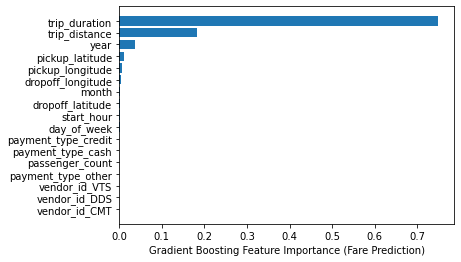

In [121]:
# Fare prediction - feature importance

sorted_idx = gboost_f_final.feature_importances_.argsort()
plt.barh(x_val.columns[sorted_idx], gboost_f_final.feature_importances_[sorted_idx])
plt.xlabel("Gradient Boosting Feature Importance (Fare Prediction)")

Text(0.5, 0, 'Gradient Feature Importance (Tip Prediction)')

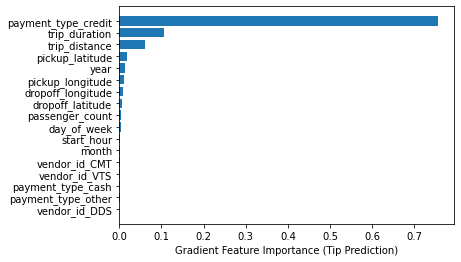

In [122]:
# Tip prediction - feature importance

sorted_idx = gboost_t_final.feature_importances_.argsort()
plt.barh(x_val.columns[sorted_idx], gboost_t_final.feature_importances_[sorted_idx])
plt.xlabel("Gradient Feature Importance (Tip Prediction)")

##### Summary

**Gradient Boosting**

Objective metric on test:

- Fare prediction: RMSE = 0.9967
- Tip prediction: RMSE = 0.5739

Parameters: 

- Fare prediction: n_estimators = 300, max_depth = 5, learning_rate = 0.1
- Tip prediction: n_estimators = 300, max_depth = 5, learning_rate = 0.1

Top 5 features:

- Fare prediction: trip duration, trip distance, year, pick-up latitude, pick-up longitude
- Tip prediction: payment type (credit), trip duration, trip distance, pick-up latitude, year

### Overall summary

#### RMSE performance

For fare prediction, Gradient Boosting was the best performing model, followed by Random Forest and finally AdaBoost. The RMSE scores for the 3 ensemble methods are detailed below.

- Random Forest: 1.0597
- AdaBoost: 1.7773
- Gradient Boosting: 0.9967

For tip prediction, RMSE scores were much closer for all three models. Random Forest was the best performing model, followed by Gradient Boosting and then AdaBoost.

- Random Forest: 0.5724
- AdaBoost: 0.6089
- Gradient Boosting: 0.5739

#### Feature importance

For fare prediction, trip duration and trip distance were the most important features across all three models. For the remaining features, year and location data were also identified as important features.

| Classifier | RandomForest | AdaBoost | GradientBoosting |
| --- | --- | --- | --- |
| Feature 1 | Trip duration | Trip duration | Trip duration
| Feature 2 | Trip distance | Trip distance | Trip distance
| Feature 3 | Year | - | Year
| Feature 4 | Drop-off longitude | - | Pick-up latitude
| Feature 5 | Drop-off latitude | - | Pick-up longitude

For tip prediction, payment type was identified as the most importnat feature across all the models. Trip duration and trip distance also ranked highly as important variables. 

| Classifier | RandomForest | AdaBoost | GradientBoosting |
| --- | --- | --- | --- |
| Feature 1 | Payment type (cash) | Payment type (credit) | Payment type (credit)
| Feature 2 | Payment type (credit) | Trip duration | Trip duration
| Feature 3 | Trip duration | - | Trip distance
| Feature 4 | Trip distance | - | Pick-up latitude
| Feature 5 | Drop-off longitude | - | Year

#### Potential improvements

Due to the computationally expensive nature of performing Random Search for hyperparameter tuning, the number of iterations was set at a lower number of 30, and 3-fold cross validation was performed. However, given more iterations of Random Search (or Grid Search), even more optimal parameters could potentially be identified to further reduce the RMSE scores.